In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import plotly.express as px

In [41]:
df = pd.read_csv("../Final_app_work/categorized_data.csv")

In [42]:
df.columns

Index(['Unnamed: 0', 'site', 'tree', 'plot', 'species', 'Date', 'longitude',
       'latitude', 'da', 'mo', 'wk', 'yr', 'average_stem_radius',
       'change_stem_radius', 'average_basal_area', 'change_basal_area',
       'average_air_temperature', 'average_air_pressure', 'average_humidity',
       'avg_solar_irradiance', 'avg_soil_water_content', 'freeze_flag',
       'air_pressure_cat', 'humidity_cat', 'solar_rank', 'solar_cat',
       'soil_moist_cat', 'growth_category'],
      dtype='object')

## KMeans Modeling

Using the elbow method to determine the best value for K.

In [43]:
numerics = ["average_air_temperature", "average_humidity", "avg_solar_irradiance", "avg_soil_water_content", "average_air_pressure"]
cats = ["species", "plot", "site"]
target = "change_basal_area"

X = df[numerics + cats].dropna()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerics),
        ("cat", OneHotEncoder(handle_unknown='ignore'), cats)
    ]
)

pipe = Pipeline(
    steps = [("preprocessor", preprocessor),
            ("kmeans", KMeans(n_clusters=3, init="k-means++", n_init=10, random_state=6021))]
)

pipe.fit(X)
labels = pipe["kmeans"].labels_

In [44]:
K_values = list(range(1, 11))
wcss = []

for k in K_values:
    pipe.set_params(kmeans__n_clusters=k)
    pipe.fit(X)
    inertia = pipe["kmeans"].inertia_
    wcss.append(inertia)


fig = px.line(
    x=K_values,
    y=wcss,
    markers=True,
    title="Elbow Plot",
    labels={"x": "Number of Clusters (K)", 
            "y": "WCSS / Inertia"}
)

fig.update_layout(height=500, width=700)
fig.show()



## KMeans Modeling with 4 clusters

In [45]:
X = df[numerics + cats]
X_clean = X.dropna()

pipe.set_params(kmeans__n_clusters=4)
pipe.fit(X_clean)

labels = pipe["kmeans"].labels_

df_clusters = df.loc[X_clean.index].copy()
df_clusters["cluster"] = labels

X_transformed = pipe["preprocessor"].transform(X_clean)
sil = silhouette_score(X_transformed, labels)
print("Silhouette score:", np.round(sil, 4))



Silhouette score: 0.2742


## KMeans Modeling with 3 clusters

In [46]:
X = df[numerics + cats]
X_clean = X.dropna()

pipe.set_params(kmeans__n_clusters=3)
pipe.fit(X_clean)

labels = pipe["kmeans"].labels_

df_clusters = df.loc[X_clean.index].copy()
df_clusters["cluster"] = labels



Checking silhouette score to see how separate the clusters are

In [47]:
X_transformed = pipe["preprocessor"].transform(X_clean)
sil = silhouette_score(X_transformed, labels)
print("Silhouette score:", np.round(sil, 4))


Silhouette score: 0.2642


## Interpreting Clusters (3)

In [48]:
df_clusters.groupby("cluster")[numerics].mean()


,average_air_temperature,average_humidity,avg_solar_irradiance,avg_soil_water_content,average_air_pressure
cluster,,,,,
0,3.084850,0.692329,73.146533,0.340895,93.180109
1,-3.897990,0.858335,21.160694,0.081367,97.926995
2,2.046448,0.829039,61.256985,0.347042,100.030181


In [49]:
df[numerics].describe()

,average_air_temperature,average_humidity,avg_solar_irradiance,avg_soil_water_content,average_air_pressure
count,13637.000000,13637.000000,13637.000000,13637.000000,13637.000000
mean,0.802599,0.783601,54.781447,0.270855,96.761753
std,3.753770,0.150727,52.828178,0.155570,3.665199
min,-11.990278,0.278074,0.000000,0.039283,89.560170
25%,-1.418288,0.679617,14.384588,0.099994,93.167482
50%,1.105700,0.807082,39.923986,0.306258,97.831217
75%,3.432845,0.901958,78.169505,0.376487,100.231667
max,12.593482,1.063439,273.265839,0.678039,105.050725


**Cluster 0:** Higher average air temperature, lower average humidity, higher solar irradiance, higher soil water content, lower air pressure

**Cluster 1:** Lower average air temperature, higher average humidity, lower solar irradiance, lower soil water content, average air pressure

**Cluster 2:** Higher average air temperature, average average humidity, higher solar irradiance, higher soil water content, higher air pressure



In [50]:
df_clusters.groupby("cluster")["species"].value_counts(normalize=True)


cluster  species  
0        P glauca     1.000000
1        P glauca     0.804067
         P mariana    0.195933
2        P glauca     0.854638
         P mariana    0.145362
Name: proportion, dtype: float64

In [51]:
df_clusters.groupby("cluster")["species"].value_counts()


cluster  species  
0        P glauca     5344
1        P glauca     3045
         P mariana     742
2        P glauca     3851
         P mariana     655
Name: count, dtype: int64

In [52]:
df_clusters.groupby("cluster")["site"].value_counts(normalize=True)


cluster  site
0        AK      0.998316
         NWT     0.001684
1        NWT     0.637180
         AK      0.362820
2        NWT     1.000000
Name: proportion, dtype: float64

In [53]:
df_clusters.groupby("cluster")["site"].value_counts()


cluster  site
0        AK      5335
         NWT        9
1        NWT     2413
         AK      1374
2        NWT     4506
Name: count, dtype: int64

In [54]:
df_clusters.groupby("cluster")["plot"].value_counts(normalize=True)


cluster  plot
0        1       0.294723
         6       0.223615
         3       0.213885
         4       0.157186
         2       0.063810
         5       0.046781
1        3       0.360444
         1       0.259572
         2       0.235279
         5       0.091101
         4       0.053604
2        1       0.315579
         3       0.285397
         4       0.253662
         2       0.145362
Name: proportion, dtype: float64

**Cluster 0:** All P glauca species, almost all AK site, has a mix from all plots (1-6) and contains all of plot 6

**Cluster 1:** 80/20 split with P glauca species dominating but half of P mariana species, split between AK and NWT sites, all plots except 6 represented with plot 3 plurality

**Cluster 2:** 85/15 split with P glauca dominating but half of P mariana species, split between, all from NWT site, mix of plots 1-4

## Clusters & Target

In [55]:
df_clusters.groupby("cluster")[target].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,5344.0,0.168876,0.187462,0.0,0.046492,0.108460,0.235497,2.108445
1,3787.0,0.124009,0.179911,0.0,0.035601,0.078814,0.157460,3.903743
2,4506.0,0.146902,0.091985,0.0,0.084767,0.128788,0.193386,2.310371


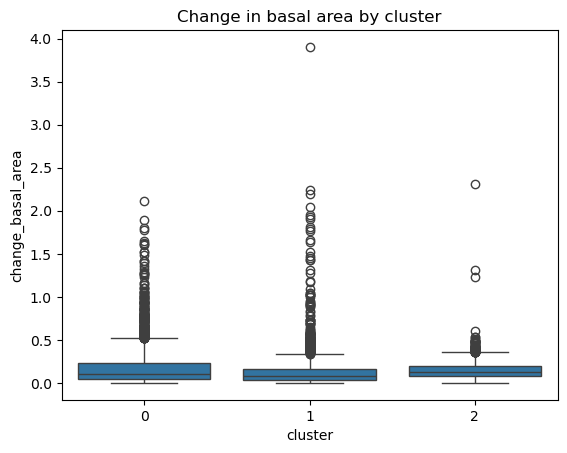

In [56]:
sns.boxplot(data=df_clusters, x="cluster", y=target)
plt.title("Change in basal area by cluster")
plt.show()


**Cluster 0:** Highest mean grow

**Cluster 1:** 

**Cluster 2:** 

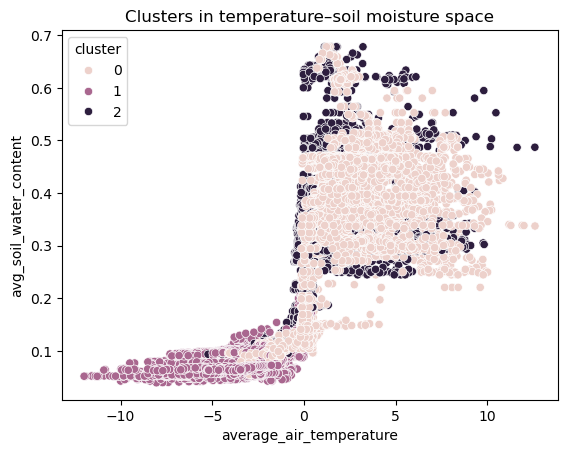

In [57]:
sns.scatterplot(
    data=df_clusters,
    x="average_air_temperature",
    y="avg_soil_water_content",
    hue="cluster"
)
plt.title("Clusters in temperature–soil moisture space")
plt.show()


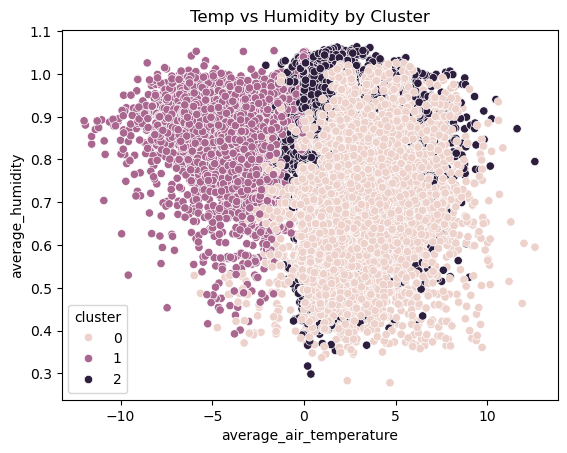

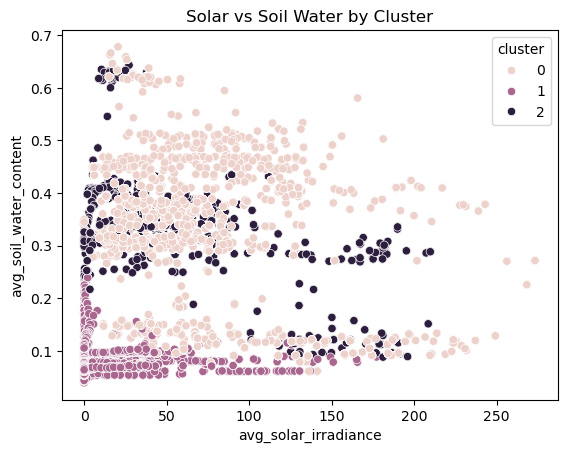

In [58]:
sns.scatterplot(
    data=df_clusters,
    x="average_air_temperature",
    y="average_humidity",
    hue="cluster"
)
plt.title("Temp vs Humidity by Cluster")
plt.show()

sns.scatterplot(
    data=df_clusters,
    x="avg_solar_irradiance",
    y="avg_soil_water_content",
    hue="cluster"
)
plt.title("Solar vs Soil Water by Cluster")
plt.show()


In [59]:
df.columns

Index(['Unnamed: 0', 'site', 'tree', 'plot', 'species', 'Date', 'longitude',
       'latitude', 'da', 'mo', 'wk', 'yr', 'average_stem_radius',
       'change_stem_radius', 'average_basal_area', 'change_basal_area',
       'average_air_temperature', 'average_air_pressure', 'average_humidity',
       'avg_solar_irradiance', 'avg_soil_water_content', 'freeze_flag',
       'air_pressure_cat', 'humidity_cat', 'solar_rank', 'solar_cat',
       'soil_moist_cat', 'growth_category'],
      dtype='object')

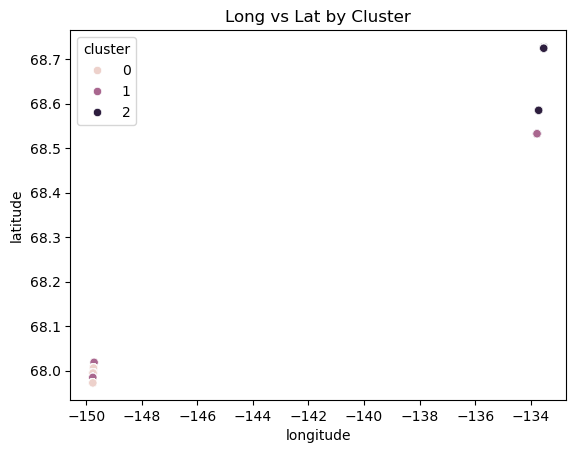

In [60]:
sns.scatterplot(
    data=df_clusters,
    x="longitude",
    y="latitude",
    hue="cluster"
)
plt.title("Long vs Lat by Cluster")
plt.show()